# perceptual decision-making


In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch_directml
from torch.utils.data import DataLoader
from sklearn.mixture import GaussianMixture 
import dataset.generate_dataset as generate_dataset
import models.neural_networks as neural_networks 
import models.latent_dynamics as latent_dynamics
import evaluation.visualise_dynamics as visualise_dynamics
import evaluation.visualise_connectivity as visualise_connectivity
import matplotlib.colors as mcolors
import scipy 

device = torch_directml.device()
print('Using {}'.format(device))

np.random.seed(0)
torch.manual_seed(0)
list_colors = list(mcolors.TABLEAU_COLORS)

Using privateuseone:0


## 1. Generate data.

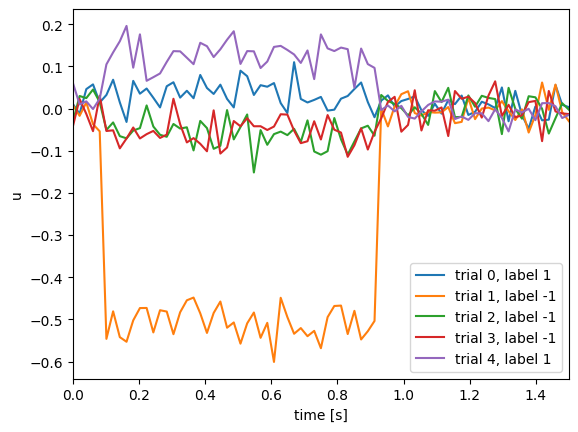

In [2]:
batch_size = 32
num_trials = batch_size * 50
t_onset = 0.1 # 5 / sampling_rate # [s]
t_offset = 0.9 # 45 / sampling_rate # [s]
t_max = 1500/1000 # [s]
sampling_rate = 1/(20/1000) #[Hz]
num_trial_to_plot = 5 # should be less than batch_size
stimulus_strength_list  = \
    3.2/100 * 2 ** np.arange(0, 5)
stimulus_strength_list = \
    np.append(stimulus_strength_list, (-stimulus_strength_list))
stimulus_strength_list = np.sort(stimulus_strength_list)

PDM_dataset_train = generate_dataset.PDMStimulus(num_trials, t_onset, t_offset, t_max, stimulus_strength_list, sampling_rate)
PDM_dataset_test = generate_dataset.PDMStimulus(int(num_trials/100), t_onset, t_offset, t_max, stimulus_strength_list, sampling_rate)

fig = PDM_dataset_train.plot_stimulus(np.arange(num_trial_to_plot))
plt.show()

0 torch.Size([32, 75]) torch.Size([32])
1 torch.Size([32, 75]) torch.Size([32])
2 torch.Size([32, 75]) torch.Size([32])
3 torch.Size([32, 75]) torch.Size([32])


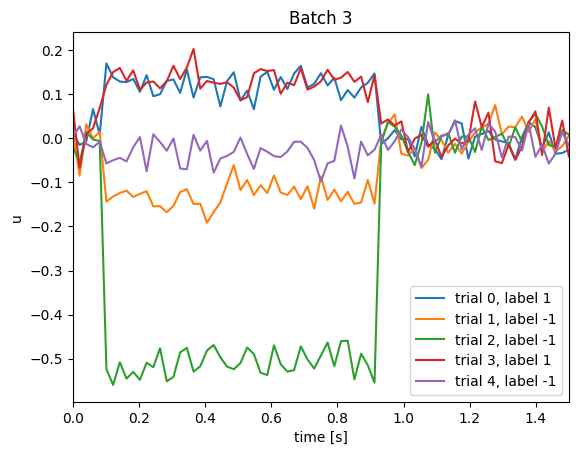

In [3]:
train_dataloader = DataLoader(PDM_dataset_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(PDM_dataset_test, batch_size=batch_size, shuffle=True)

# check a batch 
for i_batch, sample_batched in enumerate(train_dataloader):
    print(i_batch, sample_batched['stimulus'].size(),
          sample_batched['label'].size())
    
    batch_size = len(sample_batched['stimulus'])
    
    # observe 4th batch and stop.
    if i_batch == 3:
        for i_trial in range(num_trial_to_plot):
            plt.plot(PDM_dataset_train.time, sample_batched['stimulus'][i_trial, :], \
                    label='trial {:d}, label {:d}'.format(int(i_trial), int(sample_batched['label'][i_trial])))
        plt.xlim(0, max(PDM_dataset_train.time))
        plt.xlabel('time [s]')
        plt.ylabel('u')
        plt.legend()
        plt.title('Batch {}'.format(i_batch))
        plt.show()
        break

## 2. Low rank RNN  

In [4]:
input_size = 1
hidden_size = 128
output_size = 1
rank = 1
time_step = 20/1000 # s 
tau = 100/1000 # s
model = neural_networks.LowRankRNN(
    input_size, hidden_size, 
    output_size, rank, 
    time_step, tau, seed=2).to(device)
print(model)

LowRankRNN(
  (feedforward_input): LinearAmpFactor(in_features=1, out_features=128)
  (recurrent_input): RNNLayer(in_features=128, out_features=128)
  (readout): LinearAmpFactor(in_features=128, out_features=1)
)


Run simulation & Visualise a time course of each hidden node.  

try simulation for the first batch
shape of stimulus:  torch.Size([32, 75])
shape of label: torch.Size([32])


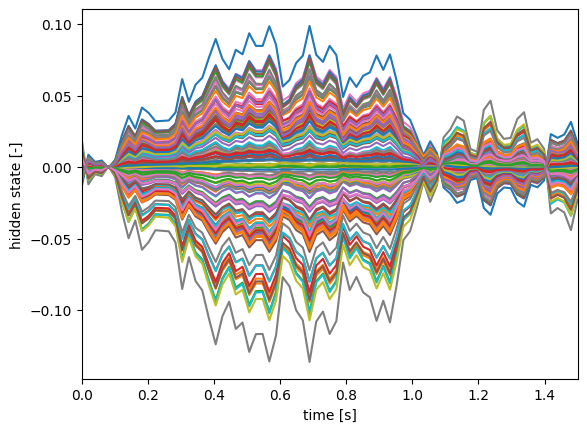

In [5]:
sample_batched = next(iter(train_dataloader))
print('try simulation for the first batch')
print('shape of stimulus: ', sample_batched['stimulus'].size())
print('shape of label:', sample_batched['label'].size())

visualise_dynamics.plot_hidden_nodes_single_trial(
    device, model, t_max, PDM_dataset_train, train_dataloader)

## 3. Train network

In [6]:
loss_fn = torch.nn.MSELoss(reduction='mean')
learning_rate = 5e-3
loss_min = 5e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
time_step_for_loss = 15 #[-] not in sec    
num_epochs = 10

In [7]:
def train_one_epoch(dataloader, model, loss_fn, optimizer, time_step_for_loss):
    num_batches = len(dataloader)
    loss_history = []
    for i_batch, sample_batched in enumerate(dataloader):
        #print(i_batch, sample_batched['stimulus'].size(),
        #      sample_batched['label'].size())      
              
        _batch_size = len(sample_batched['stimulus'])
        hidden_state = model.init_hidden(_batch_size)        
        loss = 0 
        optimizer.zero_grad()
        #print(sample_batched['stimulus'].shape)
        num_sample_points = sample_batched['stimulus'].shape[1]
        
        for i_time in range(num_sample_points):
            #print(sample_batched['stimulus'].shape)
            input_data = sample_batched['stimulus'][:, i_time].unsqueeze(dim=1).to(device)
            label_data = sample_batched['label'].float().to(device)
            hidden_state = hidden_state.to(device)
            output, hidden_state = model(input_data, hidden_state)
            
            if i_time >=(num_sample_points - time_step_for_loss):
                #print(output.shape)
                #print(loss_fn(output.squeeze().to(device), label_data))
                loss += loss_fn(output.squeeze().to(device), label_data)
        
        # Backpropagation
        loss.backward()
        optimizer.step()

        loss = loss.item() 
        
        if i_batch % 25 == 0 or i_batch == num_batches-1:
            print(f"loss: {loss:>7f}, batch [{(i_batch+1):>5d}/{num_batches:>5d}]")
        
        loss_history.append(loss)

    return loss_history 

def test(dataloader, model, loss_fn, time_step_for_loss):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0 
    correct = 0
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(dataloader):
            _batch_size = len(sample_batched['stimulus'])
            hidden_state = model.init_hidden(_batch_size)
            num_sample_points = sample_batched['stimulus'].shape[1]
         
            for i_time in range(num_sample_points):
                input_data = sample_batched['stimulus'][:, i_time].unsqueeze(dim=1).to(device)
                label_data = sample_batched['label'].float().to(device)
                hidden_state = hidden_state.to(device)
                output, hidden_state = model(input_data, hidden_state)   
             
            if i_time >=(num_sample_points - time_step_for_loss):
                test_loss += loss_fn(output.squeeze().to(device), label_data)

            correct += ((output.sign() * label_data) == 1).sum().item() / _batch_size

    test_loss /= num_batches
    correct /= num_batches
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

epoch : 0


/home/yota/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torch/optim/adam.py:522: UserWarning: The operator 'aten::_foreach_lerp_.Scalar' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /__w/1/s/pytorch-directml-plugin/torch_directml/csrc/dml/dml_cpu_fallback.cpp:15.)
  torch._foreach_lerp_(device_exp_avgs, device_grads, 1 - beta1)


loss: 15.006205, batch [    1/   50]
loss: 14.969925, batch [   26/   50]
loss: 14.956845, batch [   50/   50]
epoch : 1
loss: 14.938585, batch [    1/   50]
loss: 14.670522, batch [   26/   50]
loss: 12.836425, batch [   50/   50]
epoch : 2
loss: 12.475077, batch [    1/   50]
loss: 0.569741, batch [   26/   50]
loss: 0.107337, batch [   50/   50]
epoch : 3
loss: 0.108851, batch [    1/   50]
loss: 0.010954, batch [   26/   50]
loss: 0.013677, batch [   50/   50]


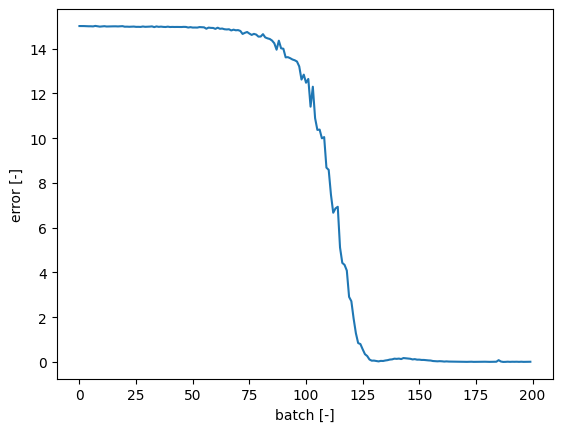

In [8]:
# train model 
loss_history = []

for i_epoch in range(num_epochs):
    print(f'epoch : {i_epoch}')
    PDM_dataset_train = generate_dataset.PDMStimulus(num_trials, t_onset, t_offset, t_max, stimulus_strength_list, sampling_rate)

    train_dataloader = DataLoader(PDM_dataset_train, batch_size=batch_size, shuffle=True)

    loss_history_one_epoch = \
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, time_step_for_loss)
    loss_history.extend(loss_history_one_epoch)

    if loss_history[-1] < loss_min:
        break
assert (loss_history[-1] < loss_min)

plt.plot(loss_history)
plt.xlabel('batch [-]')
plt.ylabel('error [-]')
plt.show()

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000231 



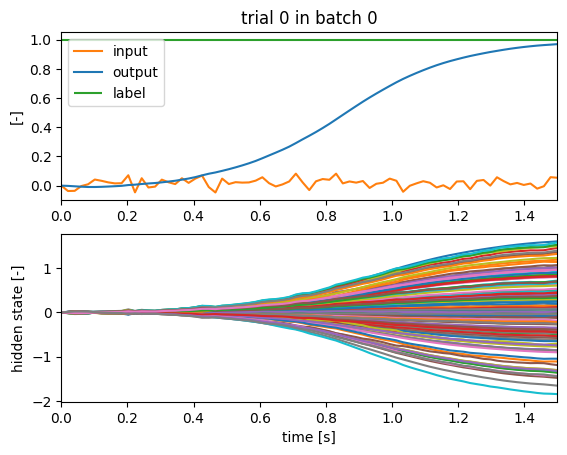

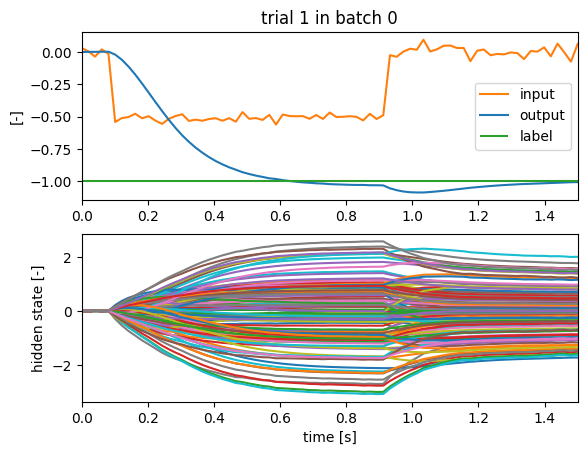

In [9]:
# test model 
test(test_dataloader, model, loss_fn, time_step_for_loss)

# visualise dynamics of trained RNN
visualise_dynamics.plot_dynamics_each_trial(
    device, model, t_max, PDM_dataset_test, test_dataloader, num_trial_to_plot=2)

## 4. Analysis of selectivity and connectivity.

Compute covariance matrix in connectivity space. 

In [10]:
input_vector = model.feedforward_input.weight.cpu().detach().numpy()
readout_vector = model.readout.weight.cpu().detach().numpy().T
input_selection_vector = model.recurrent_input.right_singular_vector.cpu().detach().numpy().T
output_vector = model.recurrent_input.left_singular_vector.cpu().detach().numpy()

# set connectivity data and compute cov matrix
connectivity_data = np.hstack((input_selection_vector, output_vector, input_vector, readout_vector))
connectivity_covariance_matrix = np.cov(connectivity_data.T)
vector_names = [rf'n$^{i}$' for i in range(1, model.rank+ 1)]
vector_names.extend([rf'm$^{i}$' for i in range(1, model.rank+ 1)])
vector_names.extend(['I', 'W'])

Plot neurons in connectivity space.

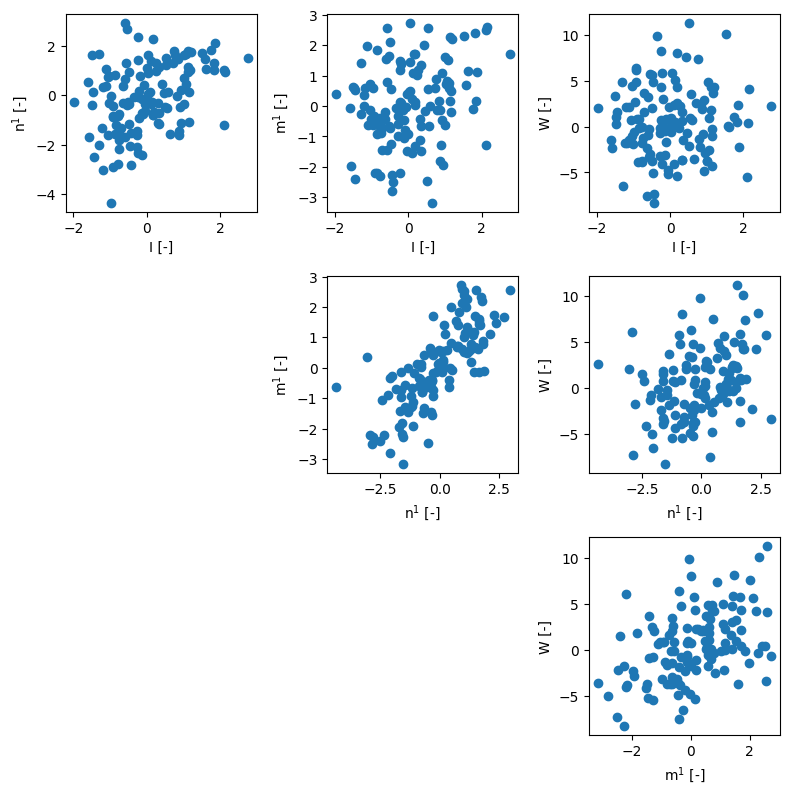

In [11]:
visualise_connectivity.plot_neurons_connectivity_space(
    connectivity_data, connectivity_covariance_matrix, model.rank)

Visualise covariance matrix.

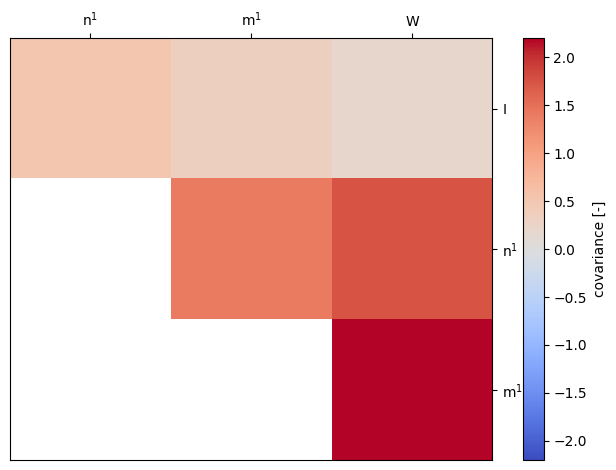

In [12]:
clim = [-2.2, 2.2]
visualise_connectivity.plot_connectivity_covariance_matrix(
    connectivity_data, connectivity_covariance_matrix, model.rank, clim)

## 5. Gaussian mixture model 

Approximate neurons in the network by a single-population GMM.

In [13]:
# fit to 4-d gaussian distribution with one population
GMM = GaussianMixture(n_components = 1, random_state=0)
GMM.fit(connectivity_data)

for i in range(connectivity_data.shape[1]):
    print(vector_names[i] + rf' mean: {GMM.means_[0][i]}')
    #GMM.covariances_

# resample from the fitted distribution
resampled_connectivity_data = \
    np.random.multivariate_normal(GMM.means_[0], GMM.covariances_[0], size=hidden_size)
print(f'shape of resampled_connectivity_data: {resampled_connectivity_data.shape}')

n$^1$ mean: -0.0651445419571246
m$^1$ mean: 0.08258263866082416
I mean: 0.016274742971290834
W mean: 0.4902746107582061
shape of resampled_connectivity_data: (128, 4)


Visualise original neurons and re-sampled neurons.

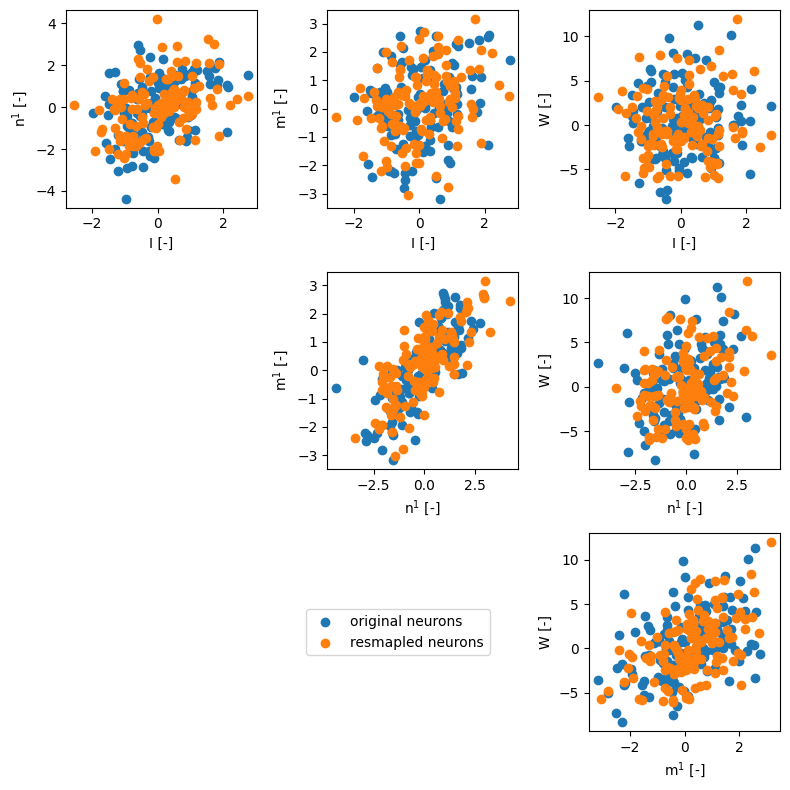

In [14]:
visualise_connectivity.plot_resampled_neurons_connectivity_space(
    resampled_connectivity_data, connectivity_data, connectivity_covariance_matrix, model.rank)

Test the network with the resampled connectivity.

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.089404 



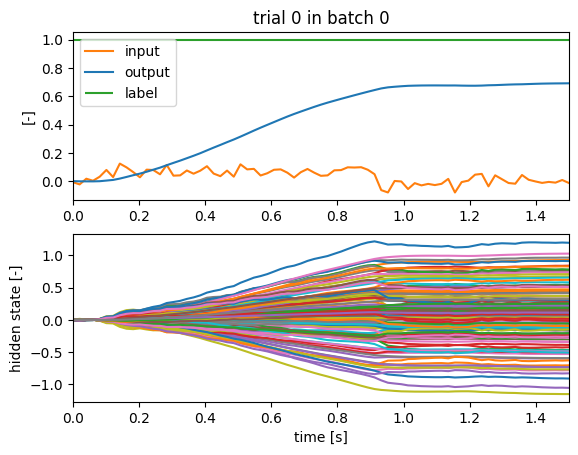

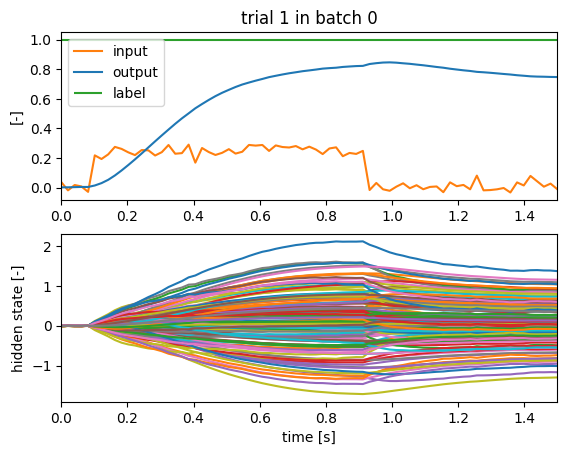

In [15]:
# Set up a network with the resampled connecitivity data.
resampled_model = \
    neural_networks.LowRankRNN(input_size, hidden_size, output_size, rank, time_step, tau).to(device)

# use resampled data for the model 
# input vector (hiddeni_size x input_size)
resampled_model.feedforward_input.weight = \
    torch.Tensor(resampled_connectivity_data[:, -2, np.newaxis])
# readout vector (output_size x hidden_size)
resampled_model.readout.weight = \
    torch.Tensor(resampled_connectivity_data[:, -1, np.newaxis].T)
# input selection vectors (rank x hidden_size)
resampled_model.recurrent_input.right_singular_vector = \
    torch.nn.Parameter(torch.Tensor(resampled_connectivity_data[:, 0:rank].T))
# output vectors (hidden_size x rank)
resampled_model.recurrent_input.left_singular_vector = \
    torch.nn.Parameter(torch.Tensor(resampled_connectivity_data[:, rank:-2]))

# test the resampled model
test(test_dataloader, resampled_model, loss_fn, time_step_for_loss)
visualise_dynamics.plot_dynamics_each_trial(
    device, resampled_model, t_max, PDM_dataset_test, test_dataloader, num_trial_to_plot=2)

## 6. Project data onto the m-I subspace.

In [16]:
stimulus_for_visualisation, label_for_visualisation = PDM_dataset_test.generate_data(systematic_change=True)
# run feedforward simulation and obtain the history of hidden state
hidden_state_history = np.empty((PDM_dataset_test.num_sample_points, stimulus_for_visualisation.shape[0], hidden_size))
for i_time in range(PDM_dataset_test.num_sample_points):
      input_data = torch.Tensor(stimulus_for_visualisation[:, i_time]).unsqueeze(dim=1)
      if i_time == 0:
            hidden_state = model.init_hidden(input_data.shape[0])
      with torch.no_grad():
            output, hidden_state = model(input_data.to(device), hidden_state.to(device))
      hidden_state_history[i_time, :, :] = hidden_state.cpu().detach().numpy()

# project data to m 
projection_m = (hidden_state_history @ output_vector).squeeze()
# project data to I
projection_I = (hidden_state_history @ input_vector).squeeze()

/tmp/ipykernel_4673/3438175607.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(projection_m[-1, i_stimulus],


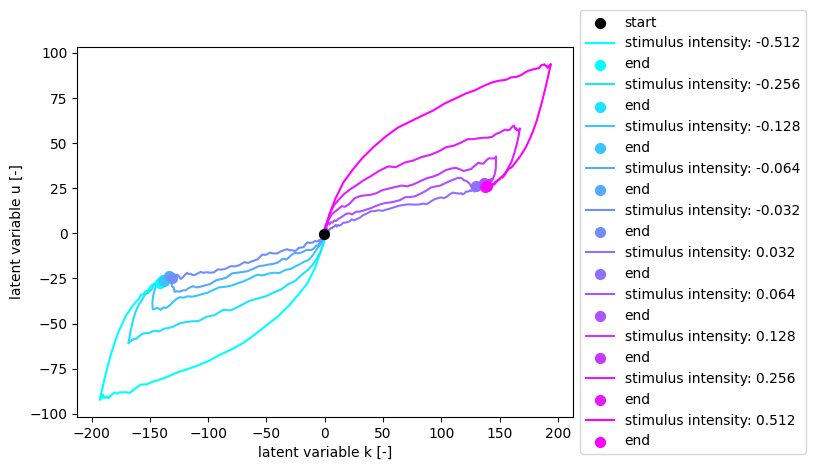

In [17]:
list_colors_systematic = plt.get_cmap('cool', len(stimulus_strength_list))
# plot trajectory of hidden state in the m-I plane
plt.scatter(projection_m[0, 0], projection_I[0, 0], s=50, color='k', label='start', zorder=10)
for i_stimulus, stimulus in enumerate(stimulus_strength_list):
    plt.plot(projection_m[:, i_stimulus], 
             projection_I[:, i_stimulus], 
             color=list_colors_systematic(i_stimulus),
             label=f'stimulus intensity: {stimulus}')
    plt.scatter(projection_m[-1, i_stimulus], 
                projection_I[-1, i_stimulus], 
                s=50, c=list_colors_systematic(i_stimulus), label='end', zorder=10)

plt.xlabel('latent variable k [-]')
plt.ylabel('latent variable u [-]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## 7. Dynamics with latent variables

In [18]:
latent_model = latent_dynamics.LatentDynamics(rank, connectivity_covariance_matrix, time_step)

# run simulation with dataset for visualisation
latent_model.run_simulation(stimulus_for_visualisation, label_for_visualisation)
correct = np.sum(label_for_visualisation == np.sign(latent_model.ks_history[:,0,-1])) / len(label_for_visualisation)
print(f"Latent dynamics: \n Accuracy: {(100*correct):>0.1f}%\n")

Latent dynamics: 
 Accuracy: 100.0%



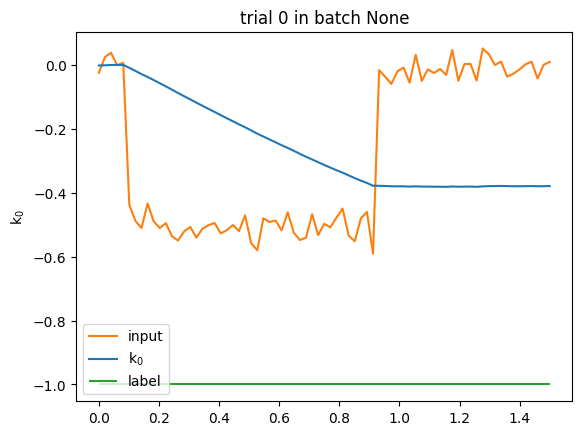

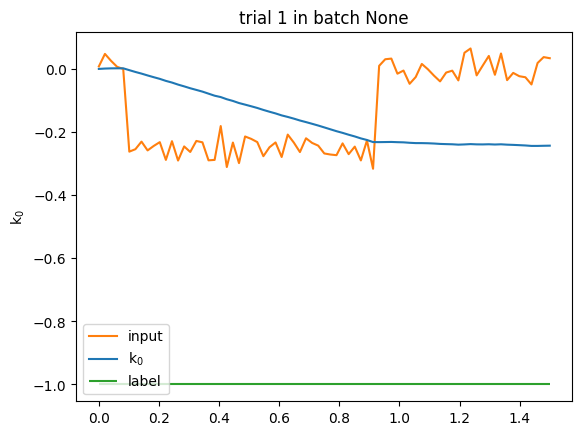

In [19]:
visualise_dynamics.plot_latent_dynamics_each_trial_PDM(
    PDM_dataset_test.time, latent_model.ks_history, 
    stimulus_for_visualisation, label_for_visualisation, 
    None, num_trial_to_plot=2)

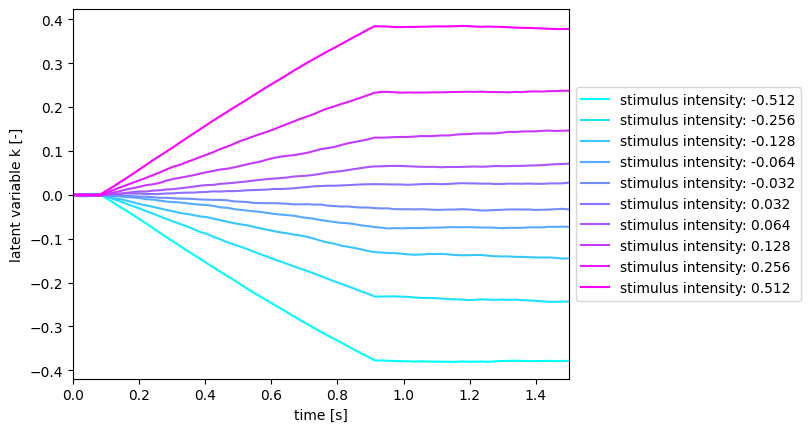

In [20]:
k0_history = latent_model.ks_history[:, 0, :].squeeze()
# plot trajectory of hidden state in the m-I plane
for i_stimulus, stimulus in enumerate(stimulus_strength_list):
    plt.plot(PDM_dataset_test.time, k0_history[i_stimulus, :], 
             color=list_colors_systematic(i_stimulus),
             label=f'stimulus intensity: {stimulus}')


plt.xlim(0, t_max)
plt.xlabel('time [s]')
plt.ylabel('latent variable k [-]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## 8. Analyse locally linear dynamics around fixed points of a trained RNN
Find fixed points by minimising enery 

In [21]:
list_initial_ks = np.expand_dims(np.arange(-1, 1.05, 0.05), axis=0)
list_energy = np.empty(list_initial_ks.shape[1])
list_derivative_ks = np.empty(list_initial_ks.shape[1])
input_data = np.zeros((rank, 1))
list_optimised_ks = None
optimisation_tol = 1e-2

for i_ks in range(list_initial_ks.shape[1]):
    ks = list_initial_ks[:, i_ks]
    list_energy[i_ks]  = latent_model.energy_function(ks, input_data)
    list_derivative_ks[i_ks] = latent_model._derivative_ks(ks, input_data, store_all=False)
    ks_optimised = scipy.optimize.minimize(latent_model.energy_function, ks, args=(input_data,))
    if ks_optimised.success:
        if list_optimised_ks is None:
            list_optimised_ks = np.empty((1, rank))
            list_optimised_ks[0, :] = ks_optimised.x
        else:
            # store if its not stored yet
            difference_between_stored_vs_new = \
                list_optimised_ks - ks_optimised.x 
            exist_in_list_or_not = \
                np.all(np.abs(difference_between_stored_vs_new)<optimisation_tol, axis=1)
            if not np.any(exist_in_list_or_not):
                list_optimised_ks = \
                    np.vstack((list_optimised_ks, ks_optimised.x))

/tmp/ipykernel_4673/1671690491.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  list_derivative_ks[i_ks] = latent_model._derivative_ks(ks, input_data, store_all=False)
/tmp/ipykernel_4673/1671690491.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  list_derivative_ks[i_ks] = latent_model._derivative_ks(ks, input_data, store_all=False)
/tmp/ipykernel_4673/1671690491.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  list_derivative_ks[i_ks] = latent_model._

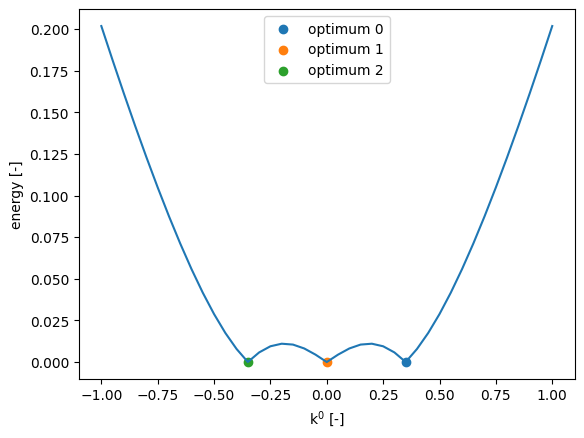

In [22]:
for i_rank in range(rank):
    for i_optimised_ks in range(list_optimised_ks.shape[0]):
        optimised_k = list_optimised_ks[i_optimised_ks, i_rank]
        optimised_ks = list_optimised_ks[i_optimised_ks, :]
        plt.scatter(optimised_k,  latent_model.energy_function(optimised_ks, input_data), label=f'optimum {i_optimised_ks}')
    plt.plot(list_initial_ks[i_rank,:], list_energy)
    plt.xlabel(rf"k$^{i_rank}$ [-]")
    plt.ylabel('energy [-]')
    plt.legend()
    plt.show()

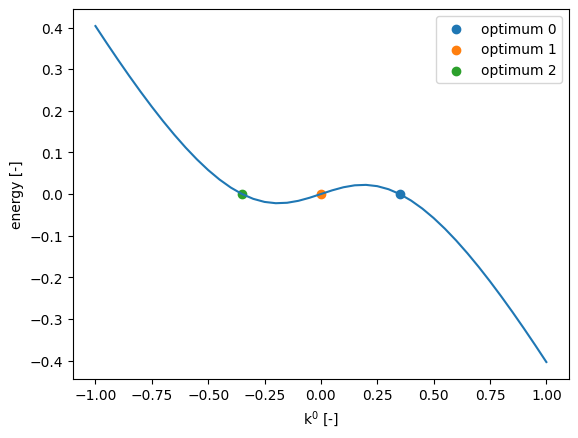

In [23]:
for i_rank in range(rank):
    for i_optimised_ks in range(list_optimised_ks.shape[0]):
        optimised_k = list_optimised_ks[i_optimised_ks, i_rank]
        optimised_ks = list_optimised_ks[i_optimised_ks, :]
        plt.scatter(optimised_k,  latent_model._derivative_ks(optimised_ks, input_data, store_all=False), label=f'optimum {i_optimised_ks}')
    plt.plot(list_initial_ks[i_rank,:], list_derivative_ks)
    plt.xlabel(rf"k$^{i_rank}$ [-]")
    plt.ylabel('energy [-]')
    plt.legend()
    plt.show()
